In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Functions

In [2]:
## SCC functions
from SCC_functions import *

In [3]:
## MACC functions and parameters

# default settings
P0 = 0
P_50=356.69970703125
s=0.07500000000000001
r=0.025
P_100=484.6875

def abatement(P, P0=P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps

## 0. Years and Initial Temperature Anomaly

In [4]:
start_year = 2020
end_year = 3000

years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [5]:
## years to calculate SCC
first_perturbed_year = start_year
last_perturbed_year = 2500
year_of_perturbation = create_years_array(start_year, last_perturbed_year)

In [6]:
T_0 = 1.2

## 1. Create Unperturbed Temperature Profile

In [7]:
delta_T = 1.5
alpha = 0.02
T = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

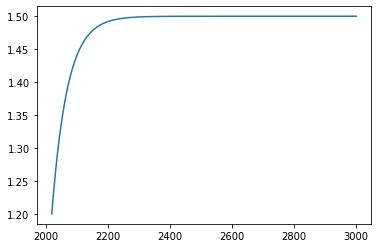

In [8]:
plt.plot(years, T)

## Total Consumption

In [9]:
consumption_growth = 0.02

In [10]:
W = create_total_consumption(years, W_fixed_year=2020, W_fixed=80, consumption_growth=consumption_growth)

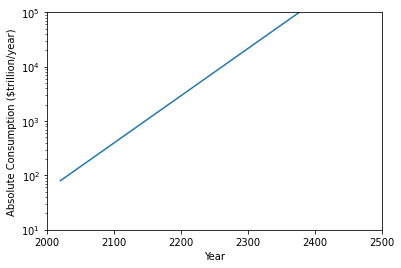

In [11]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [12]:
T_TCRE_1 = 0.00045
k_s = 0.12
size_of_perturbation = 1

In [13]:
gamma = 6
D0 = 0.00236

In [14]:
# consumption_discount = 0.035
consumption_discount = consumption_growth + 0.015

In [15]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

for j in range(len(year_of_perturbation)):
    T_perturbed = create_geometric_T_perturbed(years, T=T, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)   
    discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)
    
    time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T, 'T perturbed': T_perturbed}

    time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

    SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)
    
    
    
    if j  == 0:
        print(SCC)
        print(time_series_df)
        SCC_0 = SCC
    
    SCC = SCC - SCC_0 + P0

    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

160.8174316341241
                  W  discount function         T  T perturbed
years                                                        
2020   8.000000e+01       1.000000e+00  1.200000     1.200000
2021   8.161611e+01       9.656054e-01  1.205940     1.205991
2022   8.326486e+01       9.323938e-01  1.211763     1.211859
2023   8.494692e+01       9.003245e-01  1.217471     1.217607
2024   8.666297e+01       8.693582e-01  1.223065     1.223237
...             ...                ...       ...          ...
2996   2.401697e+10       1.460496e-15  1.500000     1.500450
2997   2.450215e+10       1.410263e-15  1.500000     1.500450
2998   2.499712e+10       1.361758e-15  1.500000     1.500450
2999   2.550210e+10       1.314921e-15  1.500000     1.500450
3000   2.601728e+10       1.269695e-15  1.500000     1.500450

[981 rows x 4 columns]


In [16]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

Text(0, 0.5, 'SCC ($)')

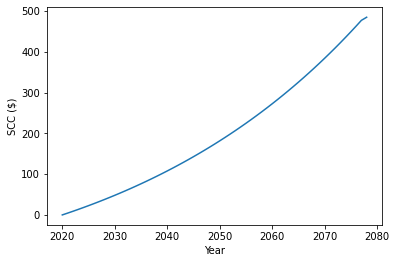

In [17]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [18]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [19]:
SCC_forecasted = []

for i in range(num_of_years):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [20]:
# SCC_forecasted

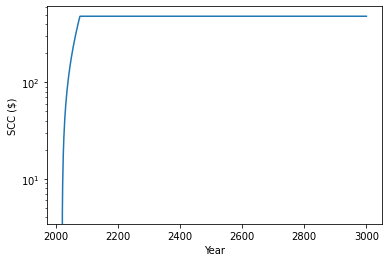

In [21]:
plt.plot(years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [22]:
forecasted_abatement = abatement(P=SCC_forecasted)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

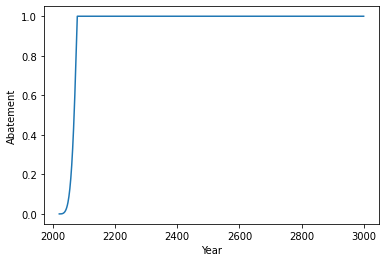

In [23]:
plt.plot(years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [24]:
CO2_baseline = 40

In [25]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

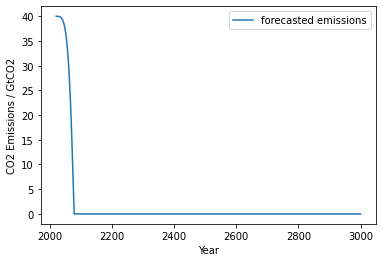

In [26]:
# plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [27]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [28]:
temperature_change = T_TCRE_1*cumulative_emissions_array

In [29]:
max(temperature_change)

0.8288391040309572

In [30]:
T_forecast_iteration0 = T_0 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

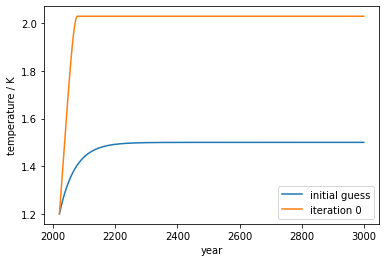

In [31]:
plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [32]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [33]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

752.035743255718
171.92947792214875


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


934.2145876286908
150.055846156286


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1085.097716325509
138.57874725917165


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1180.464428272511
133.02070301996574


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1231.6400748418025
130.31377564325422


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1257.884677369284
129.03339168285942


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1270.7345668926296
128.51897175482284


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1275.8609032885006
128.31273292944965


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1277.9157997235577
128.22990359275758


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1278.741022103833
128.1966150776283


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.0726624377862
128.1832330371762


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.205980671535
128.17785285080376


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2595803543013
128.17568967814566


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2811307451523
128.17481993174104


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.289795499008
128.17447023053646


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2932793579923
128.1743296248534


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2946801260625
128.17427309093756


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2952433387493
128.17425036009288


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2954697922025
128.1742412206068


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295560843319
128.17423754585462


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2955974525746
128.17423606832386


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295612172365
128.1742354742467


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295618090809
128.174235235389


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295620470353
128.17423513934529


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956214272065
128.17423510072734


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956218119934
128.17423508519903


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956219666012
128.17423507895364


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220288258
128.17423507644577


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220537337
128.17423507544456


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220637923
128.1742350750381


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220678177
128.17423507487538


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295622069476
128.1742350748081


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220701692
128.1742350747774


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704705
128.17423507477164


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704366
128.17423507476306


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295622070627
128.17423507475877


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220705762
128.17423507476215


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220705873
128.17423507476832


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704898
128.17423507476784


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220705366
128.17423507476227


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220706033
128.1742350747601


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295622070537
128.17423507477122


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220705064
128.17423507476187


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704948
128.1742350747637


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704611
128.17423507476266


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220705257
128.17423507476897


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704386
128.17423507476846


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.2956220704675
128.17423507476568


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1279.295622070592
128.1742350747653
1279.2956220704395
convergence condition not achieved
consumption_discount=0.035
consumption_growth=0.02
P_50=356.69970703125
s=0.07500000000000001
r=0.025
P_100=484.6875


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_81529/2285745609.py:19: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


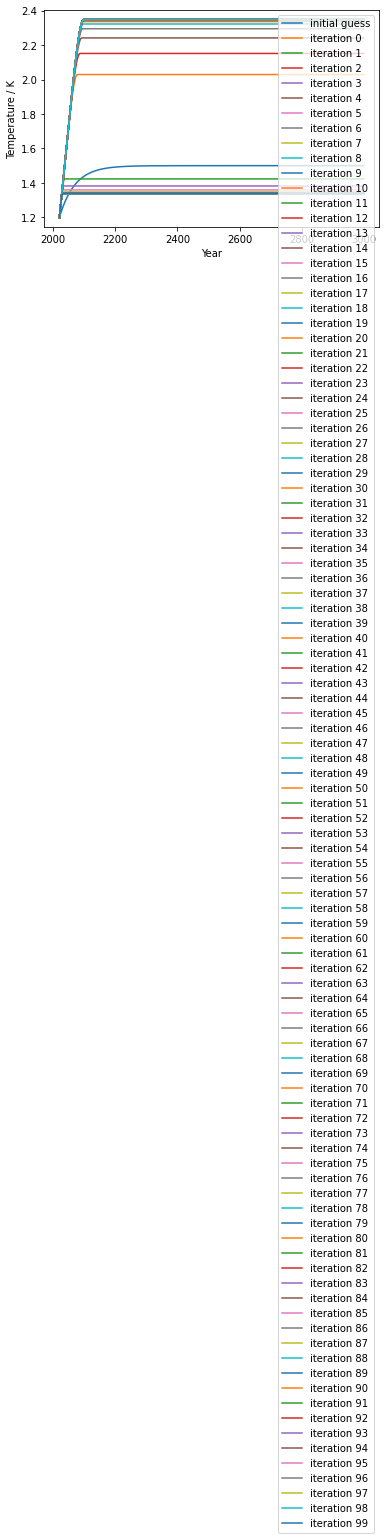

In [34]:
num_of_iterations = 99

first_perturbed_year = start_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
#     T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):

        T_perturbed = create_geometric_T_perturbed(years, T=T_forecast_iteration, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)
        discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)

        time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T_forecast_iteration, 'T perturbed': T_perturbed}
        time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

        SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)

        if j  == 0:
            print(SCC)
            SCC_0 = SCC
    
        SCC = SCC - SCC_0 + P0
#         print(SCC)


        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(num_of_years):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

#     P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted)
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE_1*cumulative_emissions_array
    
    T_forecast_iteration = T_0 + temperature_change
    
    plt.plot(years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [35]:
## peak Temperature
max(T_forecast_iteration)

1.3370961083315995

under default settings: 2.5645923835913385

using alternate pulse: 2.5696260200656615

In [36]:
SCC_list

[0.0,
 43.29410970804224,
 87.93336055048985,
 133.95066717433383,
 181.37913012866352,
 230.25198864427352,
 280.6025696623801,
 332.4642329946025,
 385.8703125074576,
 440.8540532375814,
 484.6875]